In [1]:
# Import necessary packages.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load everything.

data   = np.loadtxt('./data/data.txt').astype(int)
movies = pd.read_csv('./data/movies.txt', sep="\t", names=["id", "title", \
                    "unknown", "action", "adventure", "animation", "childrens", \
                    "comedy", "crime", "documentary", "drama", "fantasy", 
                    "film-noir", "horror", "musical", "mystery", "romance", \
                    "sci-fi", "thriller", "war", "western"])
train  = np.loadtxt('./data/train.txt').astype(int)
test   = np.loadtxt('./data/test.txt').astype(int)

In [388]:
def grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """

    grad = reg * Ui - Vj * np.transpose((Yij - mu - np.dot(np.transpose(Ui), Vj) - ai - bj))
    return grad * eta
    

def grad_V(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    grad = reg * Vj - Ui * (Yij - mu - np.dot(np.transpose(Ui), Vj) - ai - bj)
    
    return grad * eta

def grad_a(ai, Yij, Ui, Vj, bj, mu, reg, eta):
    '''    
    Returns the gradient of the regularized loss function with
    respect to ai multiplied by eta.  
    '''  
    grad = reg * ai - (Yij - mu - np.dot(np.transpose(Ui), Vj) - ai - bj)
    
    return grad * eta
    

def grad_b(bj, Yij, Ui, Vj, ai, mu, reg, eta):
    '''    
    Returns the gradient of the regularized loss function with
    respect to bj multiplied by eta.  
    '''      
    grad = reg * bj - (Yij - mu - np.dot(np.transpose(Ui), Vj) - ai - bj)
    
    return grad * eta

def get_err(U, V, Y, a, b, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    
    mu = np.mean(Y[:, 2])
    mu = 0
    
    # Array to store error of each individual point in.
    err_array = np.zeros(len(Y))
    
    # Calculate regularization term.
    Uf = np.linalg.norm(U, ord="fro")
    Vf = np.linalg.norm(V, ord="fro")
    af = np.linalg.norm(a, ord="fro")
    bf = np.linalg.norm(b, ord="fro")
    
    reg_term = reg/2 * (Uf**2 + Vf**2 + af**2 + bf**2)

    for k in range(len(Y)):
        
        # Loop over each term, save error into array.
        i = Y[k][0]-1
        j = Y[k][1]-1
        
        ai = a[i]
        bj = b[j]
        
        Y_ij = Y[k][2]
        err_array[k] = reg_term + 1/2 * (Y_ij - mu - np.dot(np.transpose(U[i]), V[j]) - ai - bj)**2

    # Return mean regularized squared-error.
    return np.mean(err_array)

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    # Initialize U, V, a, and b as random uniform variables between -0.5 and 0.5.
    U = np.random.rand(M, K)-0.5
    V = np.random.rand(N, K)-0.5
    a = np.zeros((M, 1))
    b = np.zeros((N, 1))
    
    # Find the average of all observations in Y.
    mu = np.mean(Y[:, 2])
    mu = 0
    
    
    # Matrices to store regularized and unregularized errors in.
    err = np.zeros(max_epochs)
    reg_err = np.zeros(max_epochs)
    
    for epoch in range(max_epochs):

        # Shuffle Y after epoch.
        indices = np.arange(0, len(Y))
        np.random.shuffle(indices)
        Y = Y[indices]

        for k in range(len(Y)):
            
            # Take into account that things are not 0-indexed.
            i = Y[k][0]-1
            j = Y[k][1]-1
            Yij = Y[k][2]
            
            ai = a[i]
            bj = b[j]
            
            Ui = U[i]
            Vj = V[j]
                
            # Update U, V, a, and b with gradient descent.
            U[i] -= grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta)
            V[j] -= grad_V(Vj, Yij, Ui, ai, bj, mu, reg, eta)
            
            a[i] -= grad_a(ai, Yij, Ui, Vj, bj, mu, reg, eta)
            b[j] -= grad_b(bj, Yij, Ui, Vj, ai, mu, reg, eta)
            
          
        # Save regularized error.
        reg_err_current = get_err(U, V, Y, a, b, reg=reg)
        reg_err[epoch] = reg_err_current
        
        Uf = np.linalg.norm(U, ord="fro")
        Vf = np.linalg.norm(V, ord="fro")
        af = np.linalg.norm(a, ord="fro")
        bf = np.linalg.norm(b, ord="fro")

        reg_term = reg/2 * (Uf**2 + Vf**2 + af**2 + bf**2)
        
        # Save unregularized error.
        err[epoch] = reg_err_current - reg_term
        
        if epoch%10==0:
            print("\n K: ", K, "Epoch: ", epoch, "Error:", reg_err[epoch])
        
        # Check early stopping condition.
        if epoch > 1:
            frst_decrease = reg_err[0] - reg_err[1]
            frac_fd = eps * frst_decrease
            
            if reg_err[epoch-1] - reg_err[epoch] < frac_fd:
                
                return U, V, a, b, err[epoch]
            


    
    return U, V, a, b, err[max_epochs-1]                
        

In [389]:

M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

eta_arr = [0.003, 0.007, 0.01, 0.03]
#eta_arr = [0.03]

# Use a regularization of 0.1, as in the set it had the best performance.
# Test to see which eta performs the best.
reg = 0.1
E_in = []
E_out = []


# Compute Ein and Eout
for eta in eta_arr:
    U,V, a, b, err = train_model(M, N, 20, eta, reg, train)
    E_in.append(err)
    E_out.append(get_err(U, V, test, a, b))

plt.plot(eta_arr, E_in, label='$E_{in}$')
plt.plot(eta_arr, E_out, label='$E_{out}$')
plt.title('Error vs. eta')
plt.xlabel('eta')
plt.ylabel('Error')
plt.legend()

Factorizing with  943  users,  1682  movies.


KeyboardInterrupt: 

It seems that a learning rate of 0.03 is good for this model.  Increasing the learning rate to higher numbers results in the code getting overflow errors.

Factorizing with  943  users,  1682  movies.

 K:  20 Epoch:  0 Error: 20.399202797796537

 K:  20 Epoch:  0 Error: 91.41999452716452

 K:  20 Epoch:  0 Error: 163.57229991364616

 K:  20 Epoch:  0 Error: 224.2092959791145

 K:  20 Epoch:  0 Error: 273.580626747435

 K:  20 Epoch:  10 Error: 154.34984572383615

 K:  20 Epoch:  0 Error: 316.8801203734301

 K:  20 Epoch:  10 Error: 155.00961963357022

 K:  20 Epoch:  20 Error: 139.56158008717935

 K:  20 Epoch:  30 Error: 136.8008978921734

 K:  20 Epoch:  0 Error: 636.1593918712687

 K:  20 Epoch:  10 Error: 223.3330366318299

 K:  20 Epoch:  20 Error: 186.72886882049863


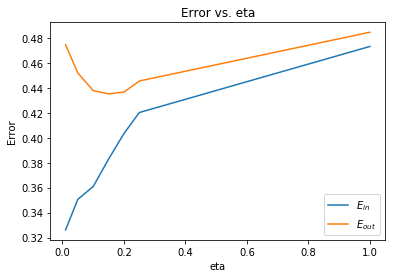

In [83]:

M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

reg_arr = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 1]

# Use a learning rate of 0.03, as in the set it had the best performance.
# Test to see which eta performs the best.
eta = 0.03
E_out = []
E_in = []


# Compute Ein and Eout
for reg in reg_arr:
    U,V, a, b, err = train_model(M, N, 20, eta, reg, train, eps=0.00001)
    E_in.append(err)
    E_out.append(get_err(U, V, test, a, b))
    
plt.plot(reg_arr, E_in, label='$E_{in}$')
plt.plot(reg_arr, E_out, label='$E_{out}$')
plt.title('Error vs. eta')
plt.xlabel('eta')
plt.ylabel('Error')
plt.legend()

From this plot, it appears that a regularization of 0.15 produces the best results.  From these parameters, we thus produce our final model.

In [390]:
# Create final model.
U,V, a, b, err = train_model(M, N, 20, 0.03, 0.15, data)


 K:  20 Epoch:  0 Error: 522.9456616583898


In [413]:
# Mean-center datasets.
U_mc = np.transpose(U) - np.transpose(np.array([np.mean(np.transpose(U), axis=1)])) 
V_mc = np.transpose(V) - np.transpose(np.array([np.mean(np.transpose(V), axis=1)]))


# Perform SVD.
A_U, S_U, B_U = np.linalg.svd(U_mc)
A_V, S_V, B_V = np.linalg.svd(V_mc)
print(S_V)

# Calculate U tilde and V tilde.
U_tilde = np.dot(np.transpose(A_U[:, 0:3]), U_mc)
V_tilde = np.dot(np.transpose(A_V[:, 0:3]), V_mc)

[13.96484131 10.94076973 10.35061946  9.91571434  9.83738566  9.72548356
  9.55846632  9.44749727  9.38450148  9.15698191  9.1404127   9.0353373
  9.01753698  8.89831924  8.78297778  8.63972312  8.57628454  8.35462286
  8.20739894  8.05561303]


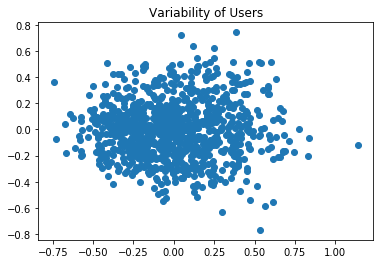

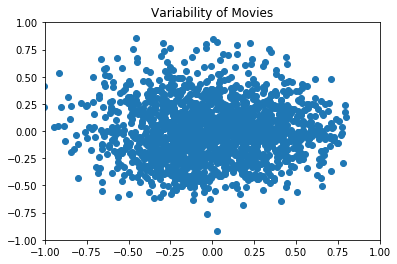

In [482]:
plt.title("Variability of Users")
plt.plot(U_tilde[0], U_tilde[1], "o")
plt.show()


plt.title("Variability of Movies")
plt.plot(V_tilde[0], V_tilde[1], "o")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

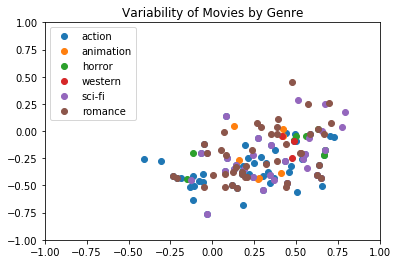

In [481]:


for i in range(n_movies):
    movie_index = i + 1
    pop = len(np.where(data[:, 1] == movie_index)[0])
    mov_pop[i] = pop

threshold = 150
pop_movies = movies.iloc[np.where(mov_pop > threshold)[0]]

action = pop_movies[pop_movies['action'] == 1]
act_id = np.array(action['id'])-1

animation = pop_movies[pop_movies['animation'] == 1]
ani_id = np.array(animation['id'])-1

horror = pop_movies[pop_movies['horror'] == 1]
hor_id = np.array(horror['id'])-1

western = pop_movies[pop_movies['western'] == 1]
wes_id = np.array(western['id'])-1

scifi = pop_movies[pop_movies['sci-fi'] == 1]
sci_id = np.array(scifi['id'])-1

romance = pop_movies[pop_movies['romance'] == 1]
rom_id = np.array(romance['id'])-1

plt.plot(V_tilde[0, act_id], V_tilde[1, act_id], "o", label="action")
plt.plot(V_tilde[0, ani_id], V_tilde[1, ani_id], "o",label="animation")
plt.plot(V_tilde[0, hor_id], V_tilde[1, hor_id], "o", label="horror")
plt.plot(V_tilde[0, wes_id], V_tilde[1, wes_id], "o", label="western")
plt.plot(V_tilde[0, sci_id], V_tilde[1, sci_id], "o", label="sci-fi")
plt.plot(V_tilde[0, rom_id], V_tilde[1, rom_id], "o", label="romance")

plt.title("Variability of Movies by Genre")
plt.legend()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()



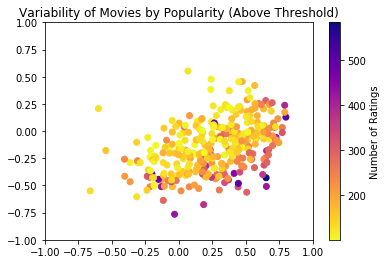

In [480]:
import matplotlib.cm as cm

# Array indicating movie popularity.
mov_pop = np.zeros(n_movies)

for i in range(n_movies):
    movie_index = i + 1
    pop = len(np.where(data[:, 1] == movie_index)[0])
    mov_pop[i] = pop
    
threshold = 100

pop_movies = np.array(movies.iloc[np.where(mov_pop > threshold)[0]]['id'])-1
    
plt.title("Variability of Movies by Popularity (Above Threshold)")
plt.scatter(V_tilde[0, pop_movies], V_tilde[1, pop_movies], c=mov_pop[pop_movies], cmap = cm.plasma_r)
plt.colorbar(label="Number of Ratings")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

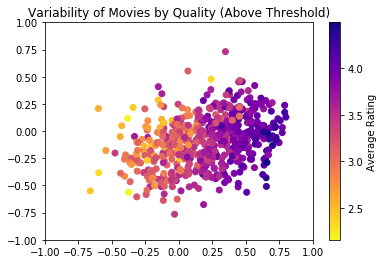

In [491]:
mov_avg = np.zeros(n_movies)
for i in range(n_movies):
    movie_index = i + 1
    avg = np.mean(data[np.where(data[:, 1] == movie_index)[0]][:, 2])
    mov_avg[i] = avg
    
    
threshold = 50

pop_movies = np.array(movies.iloc[np.where(mov_pop > threshold)[0]]['id'])-1
    
# Array indicating movie quality.    
    
plt.title("Variability of Movies by Quality (Above Threshold)")
plt.scatter(V_tilde[0, pop_movies], V_tilde[1, pop_movies], c=mov_avg[pop_movies], cmap = cm.plasma_r)
plt.colorbar(label="Average Rating")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

# 5.2.2a)

For fun, let's look at the ten worst movies in the dataset.  The worst possible score is a 1 average.  For the sake of visualizing points with the most data, let's find the most popular movies with a 1 average.

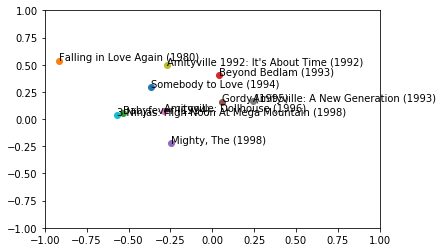

In [484]:
# Find the ten worst movies.
n_movies = 1682

# Array indicating movie average ratings and popularities
onestar_films = []
onestar_pops  = []
mov_avg = np.zeros(n_movies)
mov_pop = np.zeros(n_movies)

for i in range(n_movies):
    movie_index = i + 1
    avg = np.mean(data[np.where(data[:, 1] == movie_index)[0]][:, 2])
    if avg == 1:
        pop = len(np.where(data[:, 1] == movie_index)[0])
        onestar_films.append(movie_index)
        onestar_pops.append(pop)

onestar_films = np.array(onestar_films)
onestar_pops = np.array(onestar_pops)

onestar_idx = onestar_films[np.argsort(onestar_pops)[-10:]]-1
    
worst_titles = np.array(movies.iloc[onestar_idx]['title'])

V_tilde_worst = V_tilde[:, onestar_idx]

for i in range(10):
    plt.plot(V_tilde_worst[0][i], V_tilde_worst[1][i], "o")
    plt.text(V_tilde_worst[0][i], V_tilde_worst[1][i], worst_titles[i])

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

# 5.2.2b)

Find the ten most popular movies.

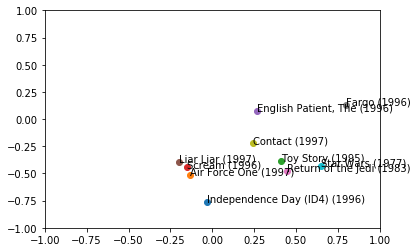

In [485]:
# Find the ten most popular movies.
n_movies = 1682

# Array indicating movie popularity.
mov_pop = np.zeros(n_movies)

for i in range(n_movies):
    movie_index = i + 1
    pop = len(np.where(data[:, 1] == movie_index)[0])
    mov_pop[i] = pop
    
top_movies = np.argsort(mov_pop)[-10:]

top_titles = np.array(movies.iloc[top_movies]['title'])

V_tilde_top = V_tilde[:, top_movies]

for i in range(10):
    plt.plot(V_tilde_top[0][i], V_tilde_top[1][i], "o")
    plt.text(V_tilde_top[0][i], V_tilde_top[1][i], top_titles[i])
plt.xlim(-1, 1)
plt.ylim(-1, 1)    
plt.show()

# 5.2.2c)

Find the ten best movies.  The best possible score is five stars, so we will once again sort for the most popular five star films in order for the data results to be more meaningful.

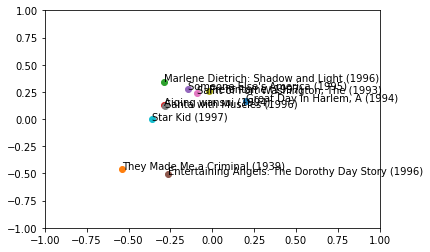

In [486]:
# Find ten best movies.
n_movies = 1682

# Array indicating movie average ratings and popularities
fivestar_films = []
fivestar_pops  = []
mov_avg = np.zeros(n_movies)
mov_pop = np.zeros(n_movies)

for i in range(n_movies):
    movie_index = i + 1
    avg = np.mean(data[np.where(data[:, 1] == movie_index)[0]][:, 2])
    if avg == 5:
        pop = len(np.where(data[:, 1] == movie_index)[0])
        fivestar_films.append(movie_index)
        fivestar_pops.append(pop)

fivestar_films = np.array(fivestar_films)
fivestar_pops = np.array(fivestar_pops)

fivestar_idx = fivestar_films[np.argsort(fivestar_pops)[-10:]]-1
    
best_titles = np.array(movies.iloc[fivestar_idx]['title'])

V_tilde_best= V_tilde[:, fivestar_idx]

for i in range(10):
    plt.plot(V_tilde_best[0][i], V_tilde_best[1][i], "o")
    plt.text(V_tilde_best[0][i], V_tilde_best[1][i], best_titles[i])
plt.xlim(-1, 1)
plt.ylim(-1, 1)    
plt.show()

# 5.2.2d)

Plot ten most popular action movies, animated movies, and horror movies.

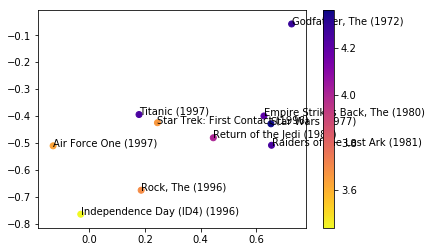

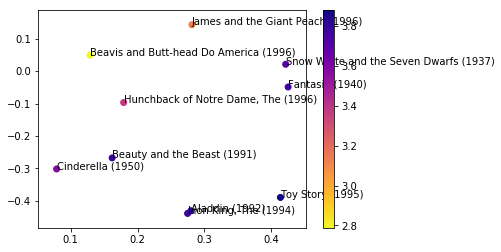

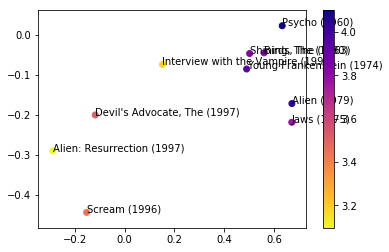

In [507]:
mov_avg = np.zeros(n_movies)
for i in range(n_movies):
    movie_index = i + 1
    avg = np.mean(data[np.where(data[:, 1] == movie_index)[0]][:, 2])
    mov_avg[i] = avg


# Array indicating movie popularity.
mov_pop = np.zeros(n_movies)

for i in range(n_movies):
    movie_index = i + 1
    pop = len(np.where(data[:, 1] == movie_index)[0])
    mov_pop[i] = pop


action = movies[movies['action'] == 1]
act_id = np.array(action['id'])
act_pop = mov_pop[act_id-1]

top_act = np.argsort(act_pop)[-10:]
top_act_id = act_id[top_act]
act_titles = np.array(action.iloc[top_act]['title'])


animation = movies[movies['animation'] == 1]
ani_id = np.array(animation['id'])
ani_pop = mov_pop[ani_id-1]

top_ani = np.argsort(ani_pop)[-10:]
top_ani_id = ani_id[top_ani]
ani_titles = np.array(animation.iloc[top_ani]['title'])


horror = movies[movies['horror'] == 1]
hor_id = np.array(horror['id'])
hor_pop = mov_pop[hor_id-1]

top_hor = np.argsort(hor_pop)[-10:]
top_hor_id = hor_id[top_hor]
hor_titles = np.array(horror.iloc[top_hor]['title'])

plt.scatter(V_tilde[0, top_act_id-1], V_tilde[1, top_act_id-1], c=mov_avg[top_act_id-1], cmap = cm.plasma_r)
for i in top_act_id:
    plt.text(V_tilde[0, i-1], V_tilde[1, i-1], movies['title'][i-1])

plt.colorbar()
plt.show()    

plt.scatter(V_tilde[0][top_ani_id-1], V_tilde[1][top_ani_id-1], c=mov_avg[top_ani_id-1], cmap = cm.plasma_r)
for i in top_ani_id:
    plt.text(V_tilde[0][i-1], V_tilde[1][i-1], movies['title'][i-1])

plt.colorbar()
plt.show()    

plt.scatter(V_tilde[0][top_hor_id-1], V_tilde[1][top_hor_id-1], c=mov_avg[top_hor_id-1], cmap = cm.plasma_r)
for i in top_hor_id:
    plt.text(V_tilde[0][i-1], V_tilde[1][i-1], movies['title'][i-1])

plt.colorbar()
plt.show()

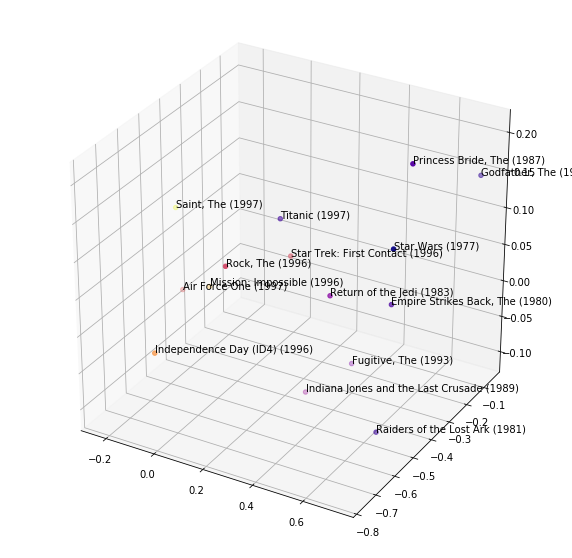

In [521]:
mov_avg = np.zeros(n_movies)
for i in range(n_movies):
    movie_index = i + 1
    avg = np.mean(data[np.where(data[:, 1] == movie_index)[0]][:, 2])
    mov_avg[i] = avg


# Array indicating movie popularity.
mov_pop = np.zeros(n_movies)

for i in range(n_movies):
    movie_index = i + 1
    pop = len(np.where(data[:, 1] == movie_index)[0])
    mov_pop[i] = pop


action = movies[movies['action'] == 1]
act_id = np.array(action['id'])
act_pop = mov_pop[act_id-1]

top_act = np.argsort(act_pop)[-15:]
top_act_id = act_id[top_act]
act_titles = np.array(action.iloc[top_act]['title'])


fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(V_tilde[0, top_act_id-1], V_tilde[1, top_act_id-1], V_tilde[2, top_act_id-1], c=mov_avg[top_act_id-1], cmap = cm.plasma_r)
for i in top_act_id:
    ax.text(V_tilde[0, i-1], V_tilde[1, i-1], V_tilde[2, i-1], movies['title'][i-1])

plt.show()    

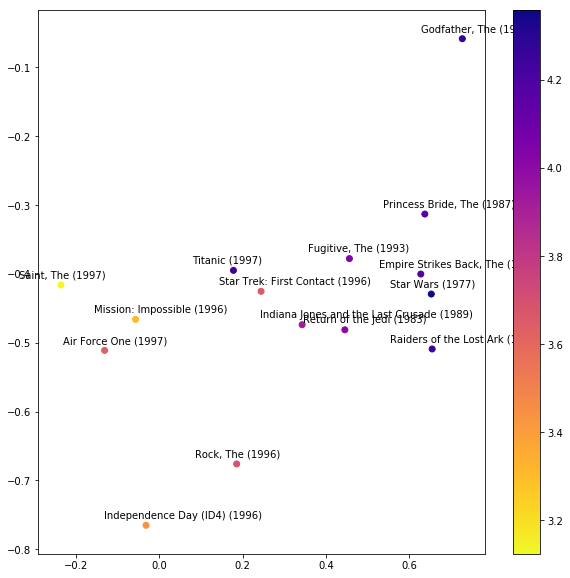

In [575]:
action = movies[movies['action'] == 1]
act_id = np.array(action['id'])
act_pop = mov_pop[act_id-1]

top_act = np.argsort(act_pop)[-15:]
top_act_id = act_id[top_act]

action.iloc[top_act]

act_titles = np.array(action.iloc[top_act]['title'])

plt.figure(figsize=(10,10))
plt.scatter(V_tilde[0, top_act_id-1], V_tilde[1, top_act_id-1], c=mov_avg[top_act_id-1], cmap = cm.plasma_r)
plt.colorbar()
for i in top_act_id:
#    if movies.iloc[i-1]["adventure"]==1:
#        plt.plot(V_tilde[0, i-1], V_tilde[1, i-1], "*")
#    else:
#        plt.plot(V_tilde[0, i-1], V_tilde[1, i-1], "o")
    plt.text(V_tilde[0, i-1]-0.1, V_tilde[1, i-1]+0.01, movies['title'][i-1])
plt.show()  



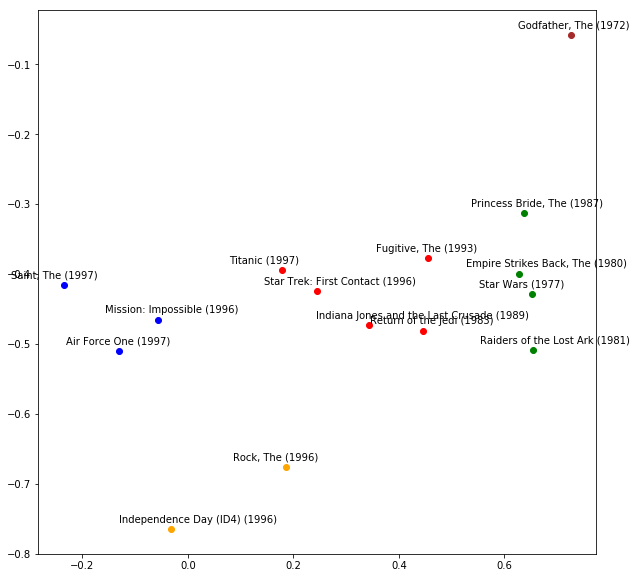

In [576]:
from sklearn.cluster import KMeans

movie_X = np.transpose(np.array([V_tilde[0, top_act_id-1], V_tilde[1, top_act_id-1]]))

n_clusters=5
kmeans = KMeans(n_clusters=n_clusters).fit(movie_X)
movie_labels = kmeans.labels_

plt.figure(figsize=(10,10))
for i in range(len(movie_X)):
    if movie_labels[i] == 0:
        plt.plot(movie_X[i][0], movie_X[i][1], "o", color="red")
    elif movie_labels[i] == 1:
        plt.plot(movie_X[i][0], movie_X[i][1], "o", color="blue")
    elif movie_labels[i] == 2:
        plt.plot(movie_X[i][0], movie_X[i][1], "o", color="green")
    elif movie_labels[i] == 3:
        plt.plot(movie_X[i][0], movie_X[i][1], "o", color="orange")
    else:
        plt.plot(movie_X[i][0], movie_X[i][1], "o", color="brown")
        
for i in top_act_id:    
    plt.text(V_tilde[0, i-1]-0.1, V_tilde[1, i-1]+0.01, movies['title'][i-1])
plt.show()  
